In [21]:
!pip install tensorflow_text

In [22]:
!pip install --upgrade tensorflow tensorflow_hub tensorflow_text

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

df = pd.read_csv("/content/Book3.csv")
df.head(5)

,Conversation,Label
0,"hi dad, how are you doing?",Normal
1,"hello, rachel I have brought you flowers with ...",Normal
2,I feel happy to tell u I opened a new bank acc...,Normal
3,I won a lottery today,Normal
4,I have been sad lately and I would like some e...,Normal


In [2]:
df.groupby('Label').describe()

Conversation                                                            \
              count unique                                                top   
Label                                                                           
Fraud          1018    660   We're calling from the telecom authority Your...   
Normal         1001    839          Thank you for your comprehensive feedback   

             
       freq  
Label        
Fraud    12  
Normal    7

In [3]:
df['Fraud']=df['Label'].apply(lambda x: 1 if x=='Fraud' else 0)
df.sample(5)

,Conversation,Label,Fraud
1030,How do you like your coffee?,Normal,0
792,Your annual physical exam is scheduled for nex...,Normal,0
644,Your account shows multiple failed login attem...,Fraud,1
657,This is the fraud department. We need to confi...,Fraud,1
234,Let’s align on the key deliverables,Normal,0


In [4]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Conversation'],df['Fraud'], stratify=df['Fraud'])

In [5]:
X_train.head(4)

1513     We're calling from a government scheme offeri...
1322    We are offering a free subscription trial. Con...
396                      Thank you for the quick response
546     Your subscription is about to expire. Renew no...
Name: Conversation, dtype: object

In [6]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", name='BERT_encoder')


In [7]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [8]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
        self.bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", name='BERT_encoder')

    def call(self, inputs):
        preprocessed_text = self.bert_preprocess(inputs)
        encoded_text = self.bert_encoder(preprocessed_text)
        return self.bert_encoder(preprocessed_text)

# Input layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

# Use the custom BertLayer
bert_outputs = BertLayer()(text_input)

# Dropout layer
l = tf.keras.layers.Dropout(0.1, name="dropout")(bert_outputs['pooled_output'])

# Dense layer with sigmoid activation
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Construct the final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)                    │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bert_layer (BertLayer)               │ [(None, 768), (None, 128,   │               0 │
│                                      │ 768), (None, 128, 768),     │                 │
│                                      │ (None, 128, 768), (None,    │                 │
│                                      │ 128, 768), (None, 128,      │                 │
│                                      │ 768), (None, 128, 768),     │                 │
│                                      │ (None, 128, 768), (None,    │                 │
│                                      │ 128, 768), (None, 128,      │                 │
│                                      │ 768), (None, 128, 768),     │                 │
│                                      │ (None, 128, 768), (None,    │                 │
│                                      │ 128, 768), (None, 768),     │                 │
│                                      │ (None, 128, 768)]           │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
len(X_train)

1515

In [10]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [11]:
y_train

1513    1
1322    1
396     0
546     1
1780    1
       ..
431     0
1403    1
954     0
229     0
1388    1
Name: Fraud, Length: 1515, dtype: int64

In [ ]:
#model.fit(X_train, y_train, epochs=10)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 286s 17s/step - accuracy: 0.6018 - loss: 0.6400 - precision: 0.7076 - recall: 0.3849


[0.6371015310287476, 0.6158415675163269, 0.732824444770813, 0.3764705955982208]

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/colab_files/reva_uni_fraud_detection_model.h5')


In [12]:
from keras.models import load_model
from keras.utils import custom_object_scope

# Ensure the BertLayer is defined in the same scope
with custom_object_scope({'BertLayer': BertLayer}):
    model = load_model('/content/drive/MyDrive/colab_files/model2.h5')


In [31]:
test_df = pd.read_csv("/content/test.csv")

In [32]:
# Read the test data, ensuring it's not empty
import numpy as np
test_df = pd.read_csv("/content/test.csv")

# Check if the DataFrame is empty and handle it appropriately
if test_df.empty:
    print("Test DataFrame is empty. Please check the file path and contents.")
else:
    test_array = test_df.values

    # Make predictions
    predictions = model.predict(test_array)
    print(predictions)
    predictions = np.where(predictions > 0.5, 1, 0)
    print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
[[0.797515]]
[[1]]


In [ ]:
print(X_test)

5797    I am back. Good journey! Let me know if you ne...
3732                               Oh is it! Which brand?
4977                  We live in the next  &lt;#&gt; mins
2041                Dunno dat's wat he told me. Ok lor...
3371    Reply to win Â£100 weekly! What professional s...
                              ...                        
2452                         Lol enjoy role playing much?
1905                              Glad to see your reply.
1362    How are you with moneY...as in to you...money ...
4923    Sun ah... Thk mayb can if dun have anythin on....
4758            see you then, we're all christmassy here!
Name: Conversation, Length: 1482, dtype: object


In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

16/16 ━━━━━━━━━━━━━━━━━━━━ 292s 17s/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[215,  35],
       [159,  96]])

Text(50.722222222222214, 0.5, 'Truth')

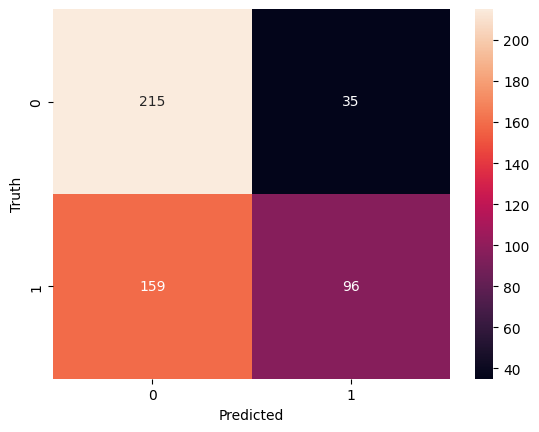

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')